# makemore: part 3

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [23]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [24]:
len(words)

32033

In [25]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [27]:
# SUMMARY + PYTORCHIFYING -----------

In [28]:
torch.manual_seed(42); # seed rng for reproducibility

In [105]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Embedding:
  def __init__(self, dim_in, dim_out):
    self.weight = torch.randn((dim_in, dim_out))

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out
  
  def parameters(self):
    return [self.weight]

class Flatten:
  def __init__(self, grouping = None):
    self.grouping = grouping

  def __call__(self, x):
    A,B, C = x.shape
    x = x.view(A, B // self.grouping, C * self.grouping)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
class LinearSequence:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
      self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP

grouping = 2
model = LinearSequence([
  Embedding(vocab_size, n_embd),
  Flatten(grouping),
  Linear(n_embd * grouping, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Flatten(grouping),
  Linear(n_hidden * grouping, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Flatten(grouping),
  Linear(n_hidden * grouping, n_hidden//3, bias=False), BatchNorm1d(n_hidden//3), Tanh(),
  Linear(n_hidden // 3, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in model.layers[:-2]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

print(sum(p.nelement() for p in model.parameters())) # number of parameters in total
for p in model.parameters():
  p.requires_grad = True

295202


In [106]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
IS_DEBUG = False

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  if IS_DEBUG:
    for layer in model.layers:
      layer.out.retain_grad()

  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i > 998 and IS_DEBUG:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2984


In [ ]:
t_lossi = torch.tensor(lossi).view(-1, 1000)

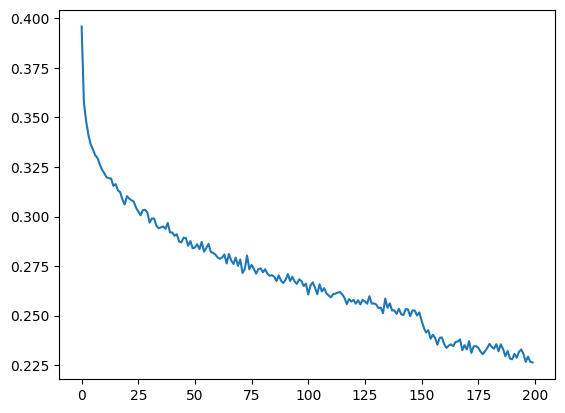

In [ ]:
plt.plot(t_lossi.mean(dim=1, keepdim=False))

In [ ]:
for layer in model.layers:
    layer.trainig = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  x = model(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.6485005617141724
val 2.0113041400909424


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      x = model(torch.tensor([context]))
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelia.
khyrin.
xitlall.
kanyan.
jazzmin.
ameryn.
jareti.
nelmar.
jceaiiv.
kaleigha.
brooklynne.
juliani.
waltis.
quinter.
giaaryn.
kaileeni.
sabina.
edi.
abethanny.
